## Importando as dependências

In [1]:
# Python
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Classificadores Scikit-learn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Auxiliadores classificação (k-fold, scaler, pipeline)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Métricas
from sklearn.metrics import accuracy_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

## Importando o dataset

In [2]:
raw_csv_data = pd.read_csv('koi_data.csv') 
df = raw_csv_data.copy() 

In [3]:
df.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


In [4]:
print("Distribuição das classes no dataset:")
display(df.groupby('koi_disposition').count().loc[:,['kepoi_name']])

Distribuição das classes no dataset:


,kepoi_name
koi_disposition,
CONFIRMED,2104
FALSE POSITIVE,3098


In [5]:
df.set_index('kepoi_name', inplace=True)

## Seperando o dataset entre X e y (features e classe)

In [6]:
y = df.koi_disposition.values
df.drop('koi_disposition', axis=1, inplace=True)
X = df.values
print('Formato X:', X.shape)
print('Formato y:', y.shape)

Formato X: (5202, 41)
Formato y: (5202,)


## Validação cruzada 5-fold

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits_5_fold = [ (train_index, test_index) for train_index, test_index in cv.split(X, y) ]

## Funções auxiliares

In [8]:
def run_classifier(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [9]:
def find_best_hyperparameter(clf, param_grid, param_name):
    # Execução do algoritmo
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy')
    grid.fit(X, y)
    
    # Mostrando os resultados como pandas dataframe
    results_df = pd.DataFrame(grid.cv_results_).set_index(f'param_{param_name}').loc[:,[ 'mean_test_score', 'std_test_score', 'rank_test_score']]
    results_df.index.names = [param_name]
    display(results_df.sort_values(by='rank_test_score'))
    
    # Encontrando o melhor parâmetro
    best_index = results_df['rank_test_score'].idxmin()
    best_accuracy = results_df.loc[best_index, 'mean_test_score']
    
    # Mostrando os resultados com Matplotlib
    plt.figure(figsize=(10, 5)) 
    results_df.loc[:, 'mean_test_score'].plot(label='Acurácia', color='green')
    plt.scatter(best_index, best_accuracy, color='red', marker='o', label=f'Melhor valor')
    plt.legend()
    plt.show()

# Classificação inicial (Baseline)

In [69]:
accuracies_gnb = []
accuracies_dt = []
accuracies_svc = []
accuracies_knn = []
accuracies_rf = []
accuracies_gtb = []
accuracies_mlp = []
for train_index, test_index in splits_5_fold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    gnb = GaussianNB()
    accuracies_gnb.append(run_classifier(gnb, X_train, X_test, y_train, y_test))
    
    dt = DecisionTreeClassifier(random_state=42)
    accuracies_dt.append(run_classifier(dt, X_train, X_test, y_train, y_test))
    
    svc = Pipeline( steps=[("scaler", StandardScaler()), ("svc", SVC(random_state=42))] )
    accuracies_svc.append(run_classifier(svc, X_train, X_test, y_train, y_test))
    
    knn = Pipeline( steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier())] )
    accuracies_knn.append(run_classifier(knn, X_train, X_test, y_train, y_test))
    
    rf = RandomForestClassifier(random_state=42)
    accuracies_rf.append(run_classifier(rf, X_train, X_test, y_train, y_test))
    
    gtb = GradientBoostingClassifier(random_state=42)
    accuracies_gtb.append(run_classifier(gtb, X_train, X_test, y_train, y_test))
    
    mlp = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42))] )
    accuracies_mlp.append(run_classifier(mlp, X_train, X_test, y_train, y_test))

c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

In [70]:
print(f'Acurácia Média Gaussian Naive Bayes: {sum(accuracies_gnb) / len(accuracies_gnb):.5f}')
print(f'Acurácia Média Decision Tree: {sum(accuracies_dt) / len(accuracies_dt):.5f}')
print(f'Acurácia Média SVM: {sum(accuracies_svc) / len(accuracies_svc):.5f}')
print(f'Acurácia Média K-NN: {sum(accuracies_knn) / len(accuracies_knn):.5f}')
print(f'Acurácia Média Random Forest: {sum(accuracies_rf) / len(accuracies_rf):.5f}')
print(f'Acurácia Média Gradient Tree Boosting: {sum(accuracies_gtb) / len(accuracies_gtb):.5f}')
print(f'Acurácia Média Multi-layer Perceptron: {sum(accuracies_mlp) / len(accuracies_mlp):.5f}')

Acurácia Média Gaussian Naive Bayes: 0.79815
Acurácia Média Decision Tree: 0.94483
Acurácia Média SVM: 0.93560
Acurácia Média K-NN: 0.89581
Acurácia Média Random Forest: 0.97040
Acurácia Média Gradient Tree Boosting: 0.97001
Acurácia Média Multi-layer Perceptron: 0.95963


# Hyperparameter Tuning

## Decision Tree

,mean_test_score,std_test_score,rank_test_score
max_depth,,,
7,0.947908,0.015105,1
6,0.946563,0.018689,2
8,0.946560,0.020261,3
9,0.945216,0.019732,4
5,0.943486,0.016900,5
10,0.943102,0.023659,6
14,0.941947,0.019458,7
11,0.941756,0.021470,8
22,0.941563,0.020402,9


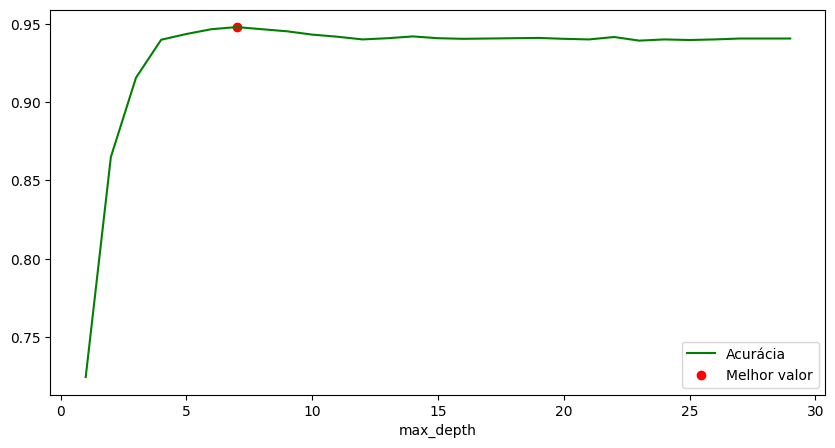

In [60]:
dt = DecisionTreeClassifier()
parameters = { 'random_state': [42], 'max_depth': [ i for i in range(1, 30) ] }
find_best_hyperparameter(dt, parameters, 'max_depth')

É possível perceber que a altura máxima da árvore é 27.  
logo, para esse caso, (max_depth >= 27) é equivalente a (max_depth = None).  
O melhor valor encontrado foi para max_depth = 7.

## SVM

In [71]:
accuracies_svc_linear = []
accuracies_svc_rbf = []
for train_index, test_index in splits_5_fold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    svc_linear = Pipeline( steps=[("scaler", StandardScaler()), ("svc", SVC(kernel='linear', random_state=42))] )
    accuracies_svc_linear.append(run_classifier(svc_linear, X_train, X_test, y_train, y_test))
    
    svc_rbf = Pipeline( steps=[("scaler", StandardScaler()), ("svc", SVC(kernel='rbf', random_state=42))] )
    accuracies_svc_rbf.append(run_classifier(svc_rbf, X_train, X_test, y_train, y_test))
print(f'Acurácia Média SVC Linear: {sum(accuracies_svc_linear) / len(accuracies_svc_linear):.5f}')
print(f'Acurácia Média SVC RBF: {sum(accuracies_svc_rbf) / len(accuracies_svc_rbf):.5f}')

Acurácia Média SVC Linear: 0.95117
Acurácia Média SVC RBF: 0.93560


Como SVC Linear apresenta uma acurária média maior do que o SVC RBF, ele foi escolhido para representar o algoritmo SVM.

## KNN

,mean_test_score,std_test_score,rank_test_score
knn__n_neighbors,,,
3,0.888321,0.026989,1
5,0.886397,0.021103,2
9,0.882937,0.025062,3
7,0.882554,0.026433,4
11,0.880439,0.026569,5
13,0.877941,0.025919,6
1,0.877360,0.023920,7
15,0.875826,0.026467,8
17,0.873518,0.026540,9


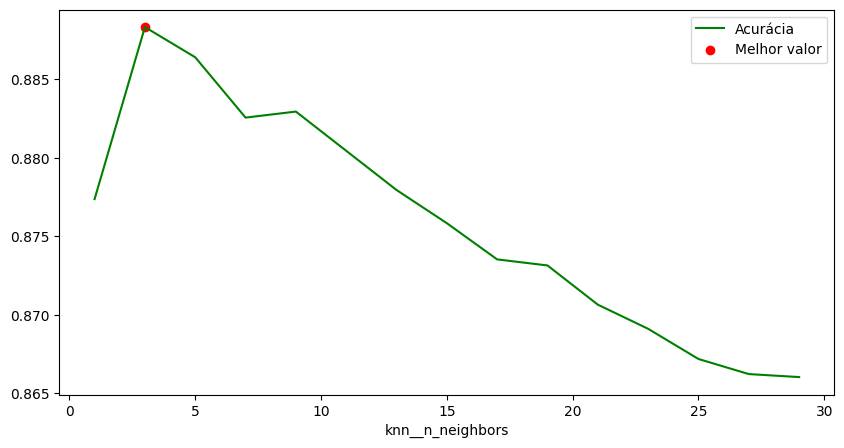

In [65]:
knn = Pipeline( steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier())] )
parameters = { 'knn__n_neighbors': [ i for i in range(1, 30, 2) ] }
find_best_hyperparameter(knn, parameters, 'knn__n_neighbors')

k=3 possui um desvio padrão maior que k=5, mas como a acurária é maior decidi seguir com ele mesmo.

## Random Forest

,mean_test_score,std_test_score,rank_test_score
n_estimators,,,
150,0.968476,0.010788,1
250,0.968476,0.011142,1
650,0.967899,0.012533,3
600,0.967899,0.012533,3
200,0.967899,0.011503,5
350,0.967899,0.012053,6
450,0.967707,0.012650,7
500,0.967707,0.012280,7
950,0.967707,0.012489,7


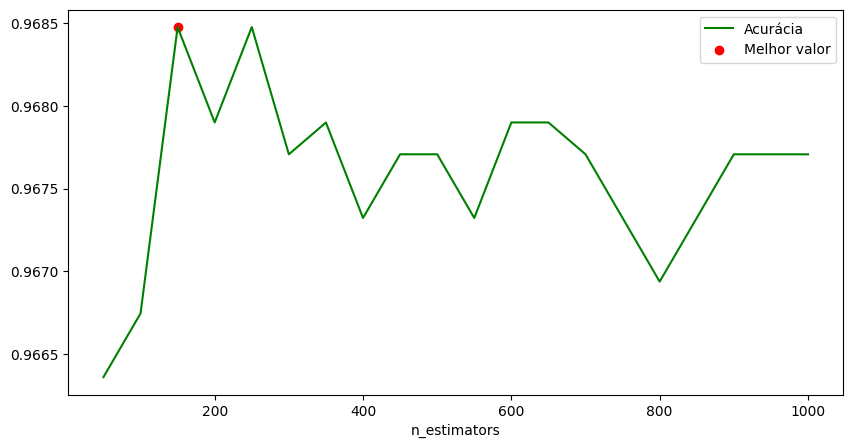

In [67]:
rf = RandomForestClassifier()
parameters = { 'random_state': [42], 'n_estimators': [ i for i in range(50, 1001, 50) ] }
find_best_hyperparameter(rf, parameters, 'n_estimators')

A variação no número de árvores não alterou significamente o desempenho do algoritmo (menos de 0.3% de variação).  
Dois valores de n_estimators estão empatados no primeiro lugar: 150 e 250.  
Como n_estimators=150 possui um menor desvio padrão, ele foi escolhido como melhhor parâmetro.

##  Gradient Tree Boosting

,mean_test_score,std_test_score,rank_test_score
n_iter_no_change,,,
2,0.966939,0.011678,1
3,0.966747,0.011740,2
4,0.966747,0.011740,2
5,0.966747,0.011740,2
15,0.966747,0.011740,2
10,0.966747,0.011740,2
20,0.966747,0.011740,2
1,0.965977,0.011422,8


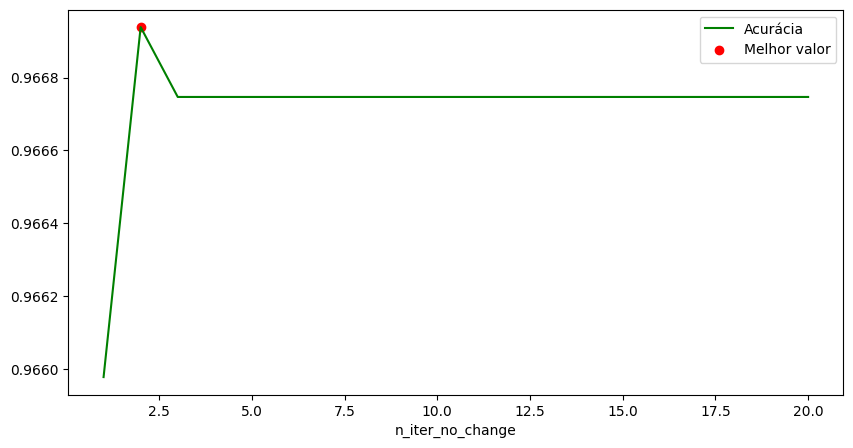

In [12]:
gtb = GradientBoostingClassifier()
parameters = { 'random_state': [42], 'n_iter_no_change': [ 1, 2, 3, 4, 5, 10, 15, 20 ] }
find_best_hyperparameter(gtb, parameters, 'n_iter_no_change')

,mean_test_score,std_test_score,rank_test_score
n_iter_no_change,,,
2,0.966939,0.011678,1
None,0.964632,0.011690,2


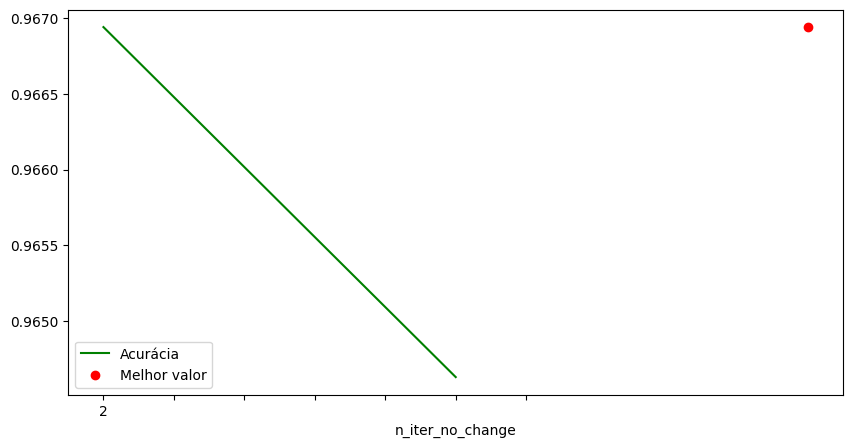

In [14]:
gtb = GradientBoostingClassifier()
parameters = { 'random_state': [42], 'n_iter_no_change': [ 2, None ] }
find_best_hyperparameter(gtb, parameters, 'n_iter_no_change')

O melhor valor para n_iter_no_change foi 2.  
*Eu fiz a verificação do None separada porque 'None' quebra o gráfico. 

##  Multi-layer Perceptron

In [73]:
accuracies_mlp_identity = []
accuracies_mlp_logistic = []
accuracies_mlp_tanh = []
accuracies_mlp_relu = []
for train_index, test_index in splits_5_fold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    mlp_identity = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='identity'))] )
    accuracies_mlp_identity.append(run_classifier(mlp_identity, X_train, X_test, y_train, y_test))
    
    mlp_logistic = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='logistic'))] )
    accuracies_mlp_logistic.append(run_classifier(mlp_logistic, X_train, X_test, y_train, y_test))
    
    mlp_tanh = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='tanh'))] )
    accuracies_mlp_tanh.append(run_classifier(mlp_tanh, X_train, X_test, y_train, y_test))
    
    mlp_relu = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='relu'))] )
    accuracies_mlp_relu.append(run_classifier(mlp_relu, X_train, X_test, y_train, y_test))

c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\guilh\GitHub\Trabalho-4---INF420\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

In [74]:
print(f'Acurácia Média MLP Identity: {sum(accuracies_mlp_identity) / len(accuracies_mlp_identity):.5f}')
print(f'Acurácia Média MLP Logistic: {sum(accuracies_mlp_logistic) / len(accuracies_mlp_logistic):.5f}')
print(f'Acurácia Média MLP Tanh: {sum(accuracies_mlp_tanh) / len(accuracies_mlp_tanh):.5f}')
print(f'Acurácia Média MLP Relu: {sum(accuracies_mlp_relu) / len(accuracies_mlp_relu):.5f}')

Acurácia Média MLP Identity: 0.95367
Acurácia Média MLP Logistic: 0.95463
Acurácia Média MLP Tanh: 0.95752
Acurácia Média MLP Relu: 0.95963


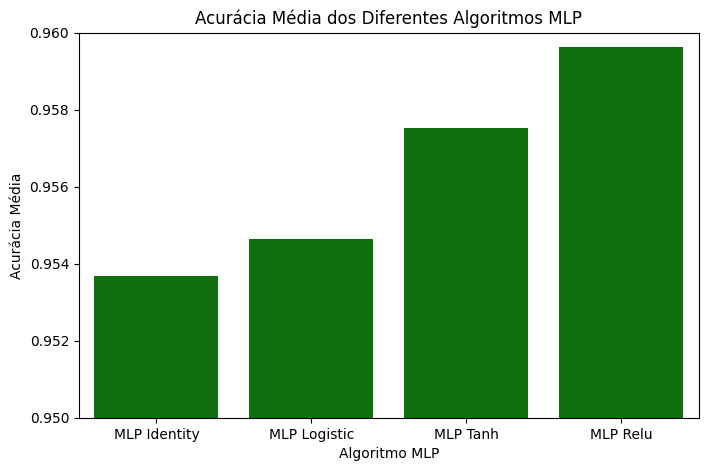

In [93]:
data = {
    'Algoritmo MLP': ['MLP Identity', 'MLP Logistic', 'MLP Tanh', 'MLP Relu'],
    'Acurácia Média': [
        sum(accuracies_mlp_identity) / len(accuracies_mlp_identity),
        sum(accuracies_mlp_logistic) / len(accuracies_mlp_logistic),
        sum(accuracies_mlp_tanh) / len(accuracies_mlp_tanh),
        sum(accuracies_mlp_relu) / len(accuracies_mlp_relu)
    ]
}
accuracies_mlp_df = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
sns.barplot(x='Algoritmo MLP', y='Acurácia Média', data=accuracies_mlp_df, color='green')
plt.title('Acurácia Média dos Diferentes Algoritmos MLP')
plt.ylim(0.95, 0.96)
plt.show()


A função de ativação que gera a melhor acurácia média é a Relu (original). Logo, ela será mantida para a versão final.

### max_iter

In [81]:
accuracies_mlp = []
for train_index, test_index in splits_5_fold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    mlp = Pipeline( steps=[("scaler", StandardScaler()), ("mlp", MLPClassifier(random_state=42, activation='relu', max_iter=600))] )
    accuracies_mlp.append(run_classifier(mlp, X_train, X_test, y_train, y_test))
print(f'Acurácia Média MLP : {sum(accuracies_mlp) / len(accuracies_mlp):.5f}')

Acurácia Média MLP : 0.95790


Com max_iter até 575 aparece warning que o algoritmo chegou no máximo de iterações antes de convergir.  
Com max_iter=600 os warnings não aparecem mais(convergiu antes do limite de iterações).  
Porém a acurácia original(max_iter=200) sem convergir é maior do que a acurácia convergindo.  
Logo, optei por mandar a versão original com os warnings mesmo.

# Classificação Final